### Unsupervised Analysis of Congressional Laws

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

Using TensorFlow backend.


__Import data__

In [2]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)

In [3]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [4]:
laws_summarys = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [5]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [6]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',

__Count Vectorizer__

In [7]:
count_vectorizer = CountVectorizer(ngram_range=(0, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]{3,100}\\b",
                                   max_df=0.8,
                                   min_df = 50)
count_vectorizer.fit(laws_list)



KeyboardInterrupt: 

In [ ]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(laws_list).transpose()

In [ ]:
np.shape(counts)

__Convert to gensim__

We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [ ]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

__Map matrix rows to words (tokens)__

We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [ ]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [ ]:
len(id2word)

## LDA
At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics (3).

In [ ]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=3)

In [ ]:
lda.print_topics(num_words=20)

In [ ]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [ ]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [ ]:
len(lda_docs)

In [ ]:
lda_docs[900]

## NMF

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [9]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [10]:
dtm

<3896x16774 sparse matrix of type '<class 'numpy.float64'>'
	with 2398375 stored elements in Compressed Sparse Row format>

In [11]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [12]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post facility service located postal facility united postal service states postal reference located office references office approved service office note office designation states facility facility referred designate facility designation facility street

Topic: 1
Keywords: health secretary program fiscal state year services care education fiscal year shall research secretary shall public health grant programs assistance health service drug eligible

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united assembled designation infrastructure congressional comm transportation states united located act designate regulation document reference law map regulation

Topic: 3
Keywords: land secretary conveyance forest federal land national forest c

__Investigate whether Topics identified match title__

In [13]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [14]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [15]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
3076,c112publ205,H.R.915 - Jaime Zapata Border Enforcement Security Task Force Act 112th Congress...,19,16,13
1441,c108publ375,H.R.4200 - Ronald W. Reagan National Defense Authorization Act for Fiscal Year 2005 ...,16,1,3
2421,c110publ375,"S.2482 - A bill to repeal the provision of title 46, United States Code, requiring a license for...",15,8,13
3719,c114publ263,"S.818 - A bill to amend the Grand Ronde Reservation Act to make technical corrections, and for o...",3,17,11
2890,c111publ383,H.R.6523 - Ike Skelton National Defense Authorization Act for Fiscal Year 2011 1...,16,1,19
323,c104publ90,"H.J.Res.153 - Making further continuing appropriations for the fiscal year 1996, and for other p...",4,5,12
997,c107publ314,H.R.4546 - Bob Stump National Defense Authorization Act for Fiscal Year 2003 107...,16,1,3
2551,c110publ78,S.375 - A bill to waive application of the Indian Self-Determination and Education Assistance Ac...,17,3,5
1903,c109publ342,H.R.1556 - To designate a parcel of land located on the site of the Thomas F. Eagleton United St...,2,3,3
2091,c109publ78,H.R.2132 - To extend the waiver authority of the Secretary of Education with respect to student ...,11,15,8


## Try LSA too!

In [ ]:
vectorizer2 = TfidfVectorizer(
    ngram_range=(1,2),  
    stop_words = custom_sw, 
    token_pattern="\\b[a-z][a-z]{2,100}\\b",
    max_df = 0.80,
    min_df = 50)

dtm2 = vectorizer2.fit_transform(laws_list) 

In [ ]:
# Fit LSA. Use algorithm = “randomized” for large datasets 

num_groups2 = 15
lsa_model = TruncatedSVD(num_groups2, algorithm = 'randomized')
dtm_lsa = lsa_model.fit_transform(dtm2)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [ ]:
features = vectorizer2.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(lsa_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

In [ ]:
lsa_df = pd.DataFrame(dtm_lsa, index = laws_df.index)

In [ ]:
rank_df(lsa_df,1,num_groups=num_groups2)
rank_df(lsa_df,2,num_groups=num_groups2)
rank_df(lsa_df,3,num_groups=num_groups2)
lsa_df.reset_index(inplace=True)
lsa_df.rename(columns={'index':'id'},inplace=True)

lsa_df = lsa_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [ ]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

__TSNE Visualization (NMF)__

In [16]:
np.shape(dtm_nmf)

(3896, 20)

In [17]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.066405
[t-SNE] Iteration 25: error = 1.6431534, gradient norm = 0.0017168
[t-SNE] Iteration 50: error = 1.7556543, gradient norm = 2.5858803
[t-SNE] Iteration 75: error = 1.7874308, gradient norm = 45773.9257812
[t-SNE] Iteration 75: error difference 0.000000. Finished.
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.787431
[t-SNE] Iteration 100: error = 1.7874308, gradient norm = 18650173440.0000000
[t-SNE] Iteration 100: error difference 0.000000. Finished.
[t-SNE] Error after 100 iterations: 1.787431


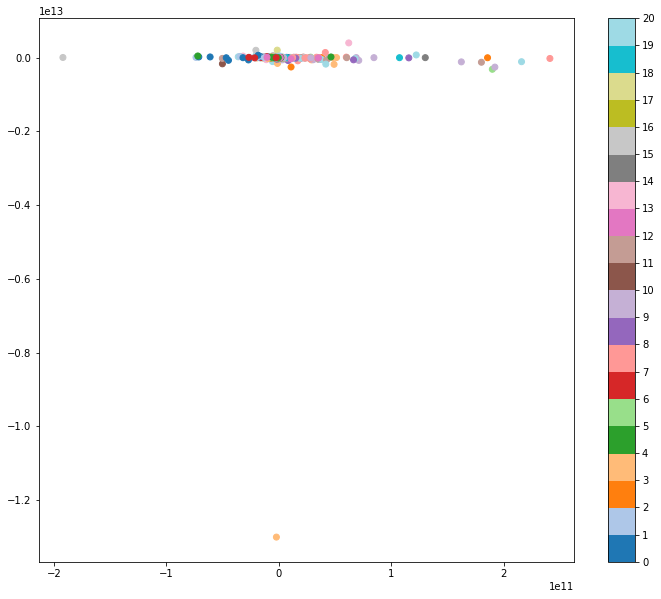

In [18]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], tsne_nmf[:,1], c=nmf_df.MAX1, cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

__TSNE Visualization (LSA)__

tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

In [ ]:
tsne_model = TSNE(learning_rate=200,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

In [ ]:
plt.figure(figsize=(20,18))
plt.scatter(tsne_lsa[:,0],
            tsne_lsa[:,1], 
            c=lsa_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20",
                                 num_groups2))
plt.colorbar(ticks=range(num_groups2+1))
plt.clim(0, num_groups2)
plt.show()